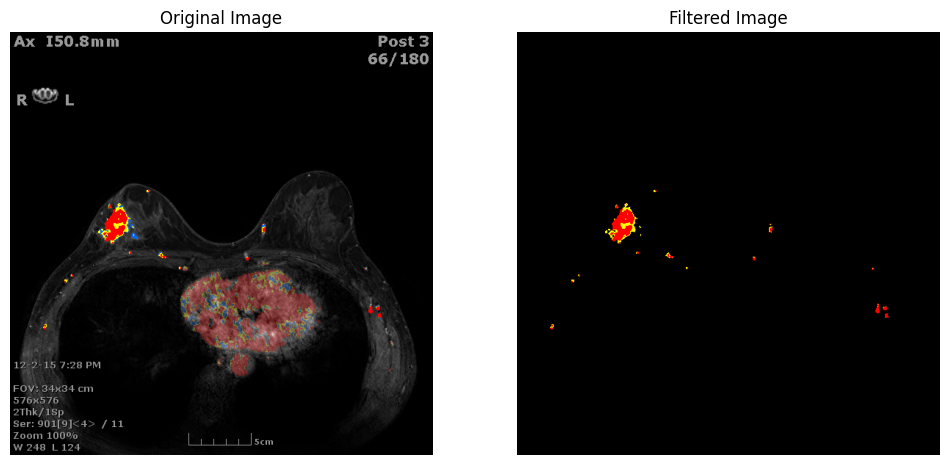

In [11]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# DICOM 파일 경로
file_path = r"C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen/001/1-cad/25563346_20181204_20151202190859_Breast MRI (Both)_contrast/FILE00066.dcm"

# DICOM 파일 읽기
dicom = pydicom.dcmread(file_path)

# DICOM 파일을 NumPy 배열로 변환
pixels = dicom.pixel_array

# DICOM 파일을 RGB 이미지로 간주
rgb_image = pixels

# 각 색상에 대한 RGB 값
colors = {
    'red': [255, 0, 0],
    'yellow': [255, 255, 0],
    'blue': [255, 102, 255],
    'green': [0, 255, 0],
    'purple': [128, 0, 255]
}

# 결과 이미지를 검은색으로 초기화
result = np.zeros_like(rgb_image)

# 각 색상에 대해
for color, rgb in colors.items():
    # 해당 색상의 픽셀만을 추출
    mask = np.all(rgb_image == rgb, axis=-1)

    # 마스크를 적용하여 해당 색상만을 가진 이미지 생성
    result[mask] = rgb_image[mask]

# 그림의 크기를 설정하여 출력
plt.figure(figsize=(12, 6))    
    
# 오리지널 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(dicom.pixel_array, cmap='gray')
plt.axis('off')
plt.title('Original Image')

# 결과 이미지 출력
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.axis('off')
plt.title('Filtered Image')

plt.show()

In [1]:
import importlib

packages = ['pydicom', 'skimage', 'mpl_toolkits.mplot3d', 'matplotlib.pyplot']

for package in packages:
    try:
        importlib.import_module(package)
        print(f"{package} is installed.")
    except ImportError:
        print(f"{package} is not installed.")

pydicom is installed.
skimage is installed.
mpl_toolkits.mplot3d is installed.
matplotlib.pyplot is installed.


In [1]:
import os
import pydicom
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 데이터 폴더 경로
data_folder = "C:/Users/shOh/Dropbox/Projects/Breast_Cancer_Classification/Breast_Cancer/SNUBH_Breast/001~100/1~100_screen"

# 병변을 나타내는 색상들의 RGB 값
lesion_colors = np.array([
    [255, 0, 0],      # Red
    [255, 255, 0],    # Yellow1
    [255, 102, 0],   # Yellow2
    [0, 102, 255],  # Blue1
    [0, 0, 255],  # Blue2
    [0, 255, 0],      # Green
    [128, 0, 255]     # Purple
])

# DICOM 파일들을 읽고 이미지 데이터를 가져오는 함수

def load_patient_images(patient_folder):
    
    # patient_folder 내의 DICOM 파일들을 가져오기
    dicom_files = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.endswith('.dcm')]

    # DICOM 파일들을 읽기
    dicoms = [pydicom.dcmread(d) for d in dicom_files]

    # 각 DICOM 파일의 이미지 위치 정보를 기준으로 정렬
    dicoms.sort(key=lambda d: float(d.ImagePositionPatient[2]))

    # 각 DICOM 파일의 pixel_array를 가져오기
    images = [d.pixel_array for d in dicoms]

    # 각 이미지를 그레이스케일로 변환하고, 병변의 색상 정보를 추출
    color_info = []
    for img in images:
        # 병변의 색상 정보를 추출
        lesion_pixels = np.any([np.all(img == color, axis=-1) for color in lesion_colors], axis=0)
        color_info.append(lesion_pixels)

        # 병변이 인식된 픽셀의 수를 출력
        print(f"Detected lesion pixels: {np.sum(lesion_pixels)}")

    return images, color_info

# 병변들을 분리하고 가장 큰 병변의 Bounding Volume을 찾는 함수
def find_largest_lesion_and_bounding_volume(images, color_info):
    # 모든 DICOM 이미지를 하나의 3D 배열로 만들기
    voxel = np.stack(images)

    # 병변 마스크를 초기화
    lesion_mask = np.zeros_like(voxel, dtype=bool)

    # 병변을 나타내는 픽셀 값 설정 (0: 배경, 1: 병변)
    for z, lesion_pixels in enumerate(color_info):
        voxel[z, lesion_pixels] = 1
        lesion_mask[z, lesion_pixels] = True  # 병변 부분을 마스크에 표시

    # 3D Connected Component Labeling 수행
    labels = measure.label(lesion_mask)

    # 각 병변의 크기를 계산하고 가장 큰 병변을 찾기
    sizes = np.bincount(labels.ravel())
    max_label = sizes[1:].argmax() + 1  # 0 레이블은 배경이므로 제외

    # 가장 큰 병변에 해당하는 픽셀들의 좌표를 찾기
    lesion_pixels = np.where(labels == max_label)

    # bounding volume의 모서리를 찾기
    min_corner = np.array([np.min(i) for i in lesion_pixels[:3]])
    max_corner = np.array([np.max(i) for i in lesion_pixels[:3]])

    return voxel, min_corner, max_corner, lesion_mask

In [13]:
# 001번 환자 폴더에서 실행
patient_folder_name = str(1).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images, color_info = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 가장 큰 병변의 Bounding Volume을 찾기
voxel, min_corner, max_corner, lesion_mask = find_largest_lesion_and_bounding_volume(images, color_info)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(voxel.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  최소 모서리: {min_corner}")
print(f"  최대 모서리: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

Detected lesion pixels: 0
Detected lesion pixels: 12
Detected lesion pixels: 98
Detected lesion pixels: 134
Detected lesion pixels: 244
Detected lesion pixels: 202
Detected lesion pixels: 224
Detected lesion pixels: 273
Detected lesion pixels: 260
Detected lesion pixels: 188
Detected lesion pixels: 105
Detected lesion pixels: 86
Detected lesion pixels: 70
Detected lesion pixels: 71
Detected lesion pixels: 121
Detected lesion pixels: 105
Detected lesion pixels: 140
Detected lesion pixels: 119
Detected lesion pixels: 122
Detected lesion pixels: 118
Detected lesion pixels: 124
Detected lesion pixels: 113
Detected lesion pixels: 239
Detected lesion pixels: 265
Detected lesion pixels: 265
Detected lesion pixels: 278
Detected lesion pixels: 308
Detected lesion pixels: 313
Detected lesion pixels: 203
Detected lesion pixels: 208
Detected lesion pixels: 203
Detected lesion pixels: 198
Detected lesion pixels: 215
Detected lesion pixels: 257
Detected lesion pixels: 303
Detected lesion pixels: 286

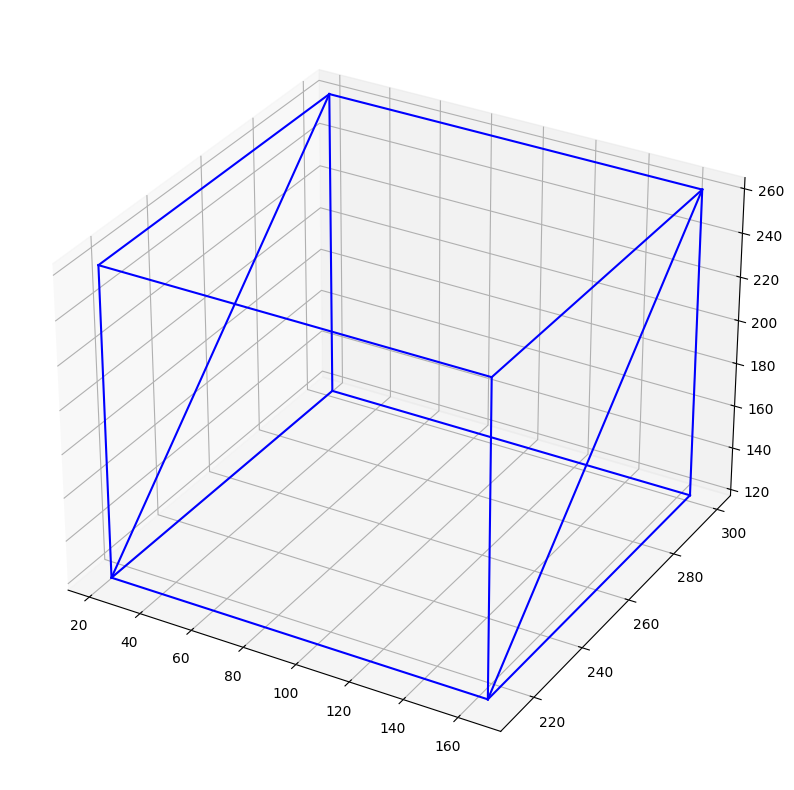

In [16]:
def draw_bounding_box(ax, min_corner, max_corner):
    # 가로 선을 그립니다.
    for z in [min_corner[2], max_corner[2]]:
        ax.plot([min_corner[0], max_corner[0]], [min_corner[1], min_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], max_corner[0]], [max_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([min_corner[0], min_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [min_corner[1], max_corner[1]], [z, z], 'b-')

    # 세로 선을 그립니다.
    for y in [min_corner[1], max_corner[1]]:
        ax.plot([min_corner[0], min_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
        ax.plot([max_corner[0], max_corner[0]], [y, y], [min_corner[2], max_corner[2]], 'b-')
    for x in [min_corner[0], max_corner[0]]:
        ax.plot([x, x], [min_corner[1], max_corner[1]], [min_corner[2], max_corner[2]], 'b-')


def visualize_bounding_box(min_corner, max_corner):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    draw_bounding_box(ax, min_corner, max_corner)
    plt.show()

# Bounding Box 시각화
visualize_bounding_box(min_corner, max_corner)

In [3]:
print(f"voxel shape: {voxel.shape}")
print(f"lesion_mask shape: {lesion_mask.shape}")
print(f"min_corner: {min_corner}")
print(f"max_corner: {max_corner}")

voxel shape: (180, 576, 576, 3)
lesion_mask shape: (180, 576, 576, 3)
min_corner: [ 22 213 120]
max_corner: [165 300 262]


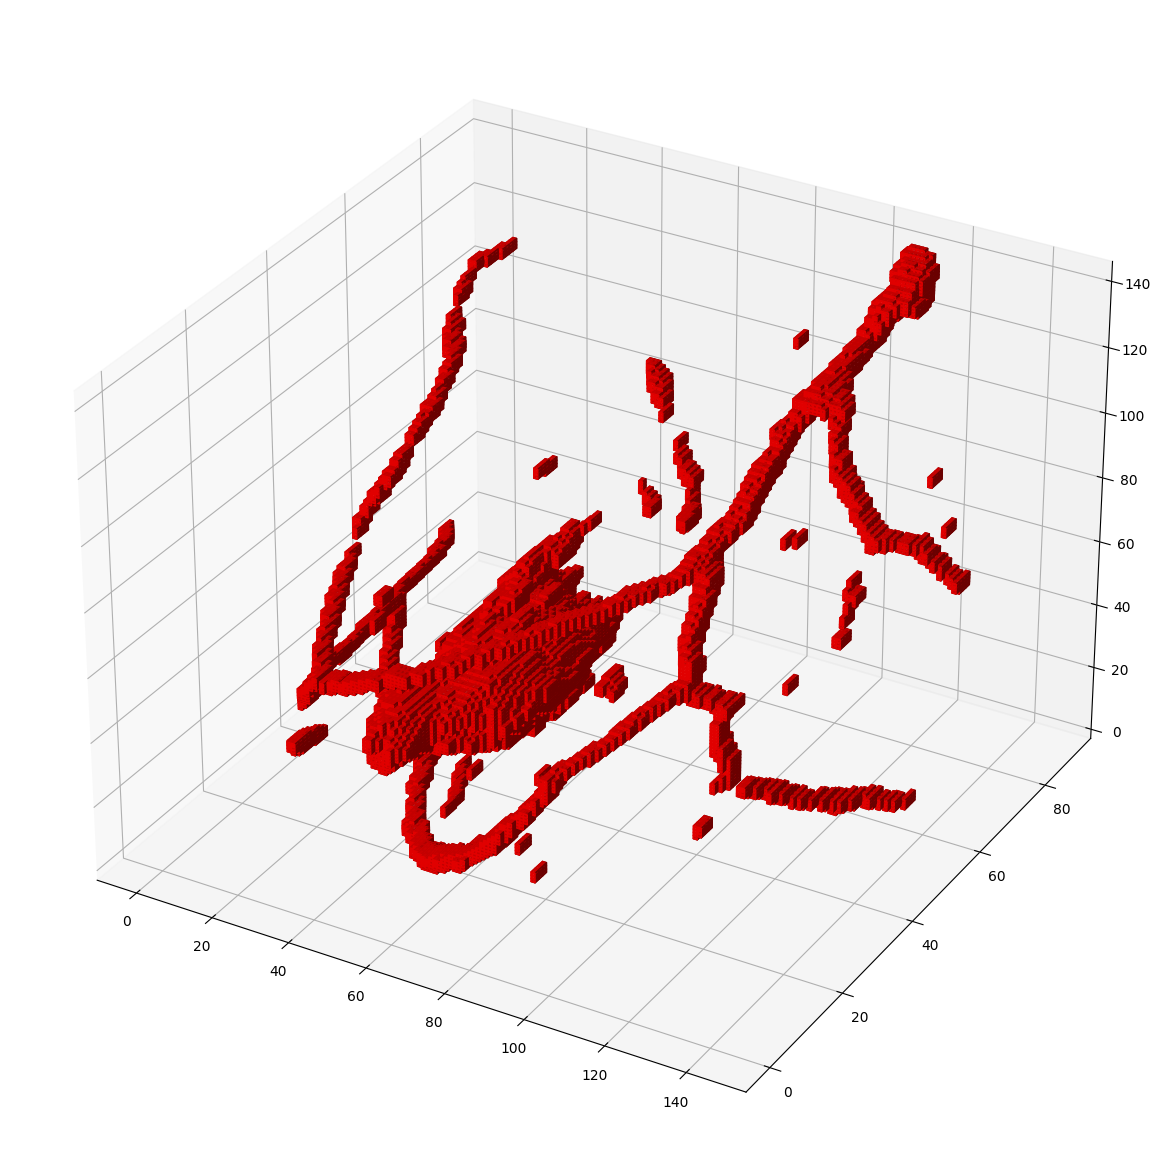

In [14]:
# Bounding Volume을 시각화하는 함수
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
lesion_mask = lesion_mask[..., 0]
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가

In [17]:
# 002번 환자 폴더에서 실행
patient_folder_name = str(2).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images, color_info = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 가장 큰 병변의 Bounding Volume을 찾기
voxel, min_corner, max_corner, lesion_mask = find_largest_lesion_and_bounding_volume(images, color_info)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(voxel.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  최소 모서리: {min_corner}")
print(f"  최대 모서리: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

Detected lesion pixels: 0
Detected lesion pixels: 58
Detected lesion pixels: 55
Detected lesion pixels: 53
Detected lesion pixels: 66
Detected lesion pixels: 18
Detected lesion pixels: 18
Detected lesion pixels: 56
Detected lesion pixels: 92
Detected lesion pixels: 128
Detected lesion pixels: 126
Detected lesion pixels: 131
Detected lesion pixels: 98
Detected lesion pixels: 110
Detected lesion pixels: 128
Detected lesion pixels: 126
Detected lesion pixels: 79
Detected lesion pixels: 64
Detected lesion pixels: 81
Detected lesion pixels: 36
Detected lesion pixels: 63
Detected lesion pixels: 45
Detected lesion pixels: 45
Detected lesion pixels: 30
Detected lesion pixels: 72
Detected lesion pixels: 59
Detected lesion pixels: 63
Detected lesion pixels: 24
Detected lesion pixels: 44
Detected lesion pixels: 30
Detected lesion pixels: 28
Detected lesion pixels: 42
Detected lesion pixels: 37
Detected lesion pixels: 81
Detected lesion pixels: 97
Detected lesion pixels: 71
Detected lesion pixels:

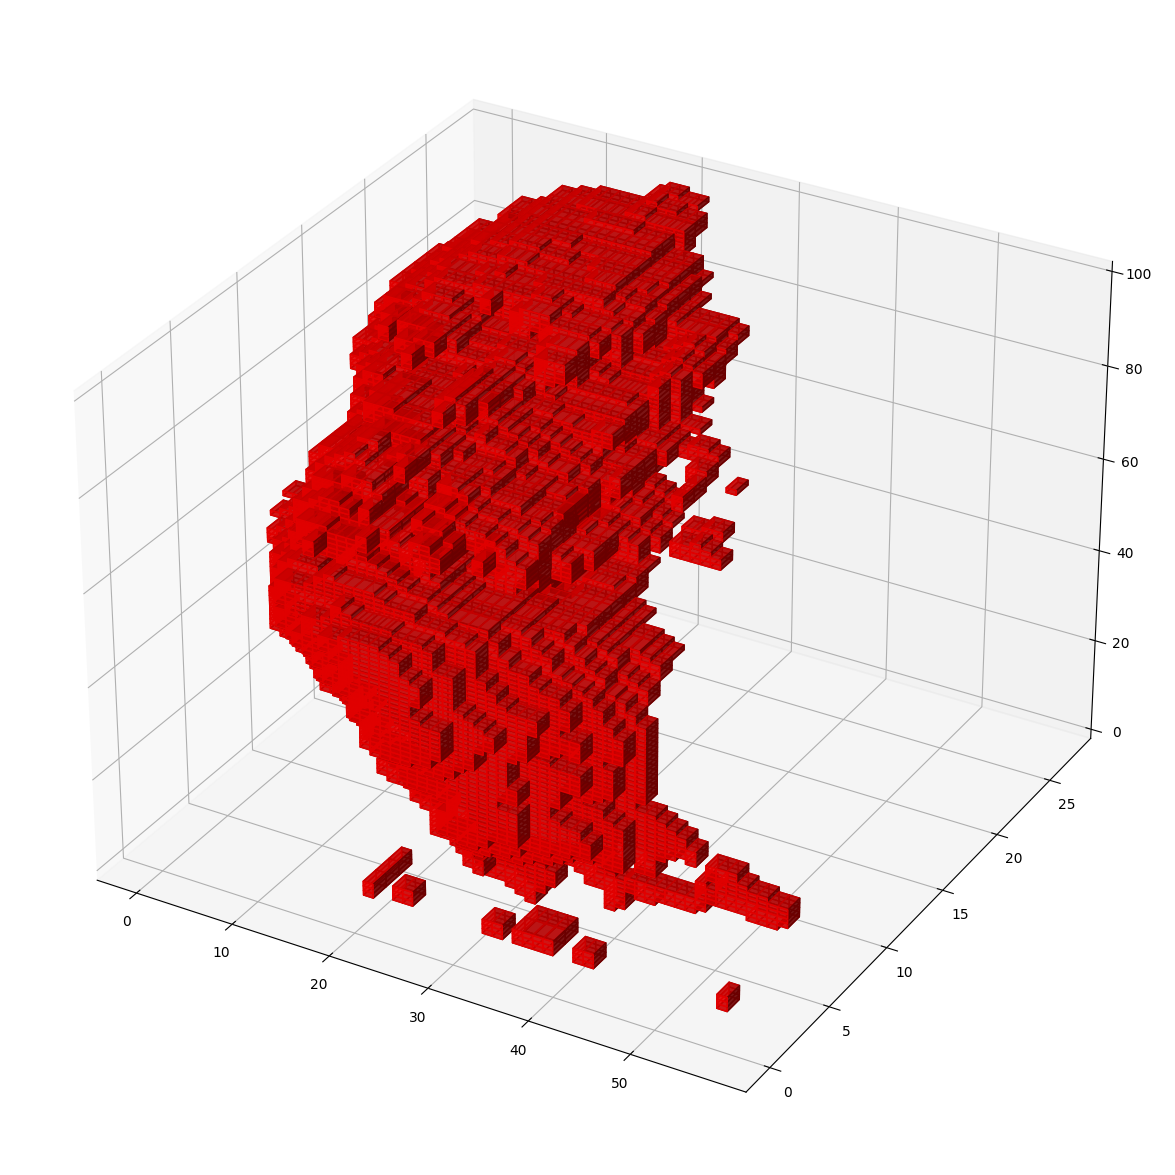

In [19]:
# Bounding Volume을 시각화하는 함수
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
lesion_mask = lesion_mask[..., 0]
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가

In [7]:
# 003번 환자 폴더에서 실행
patient_folder_name = str(3).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images, color_info = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 가장 큰 병변의 Bounding Volume을 찾기
voxel, min_corner, max_corner, lesion_mask = find_largest_lesion_and_bounding_volume(images, color_info)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(voxel.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  최소 모서리: {min_corner}")
print(f"  최대 모서리: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 15
Detected lesion pixels: 27
Detected lesion pixels: 39
Detected lesion pixels: 59
Detected lesion pixels: 64
Detected lesion pixels: 65
Detected lesion pixels: 27
Detected lesion pixels: 33
Detected lesion pixels: 12
Detected lesion pixels: 46
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 21
Detected lesion pixels: 21
Detected lesion pixels: 18
Detected lesion pixels: 9
Detected lesion pixels: 12
Detected lesion pixels: 

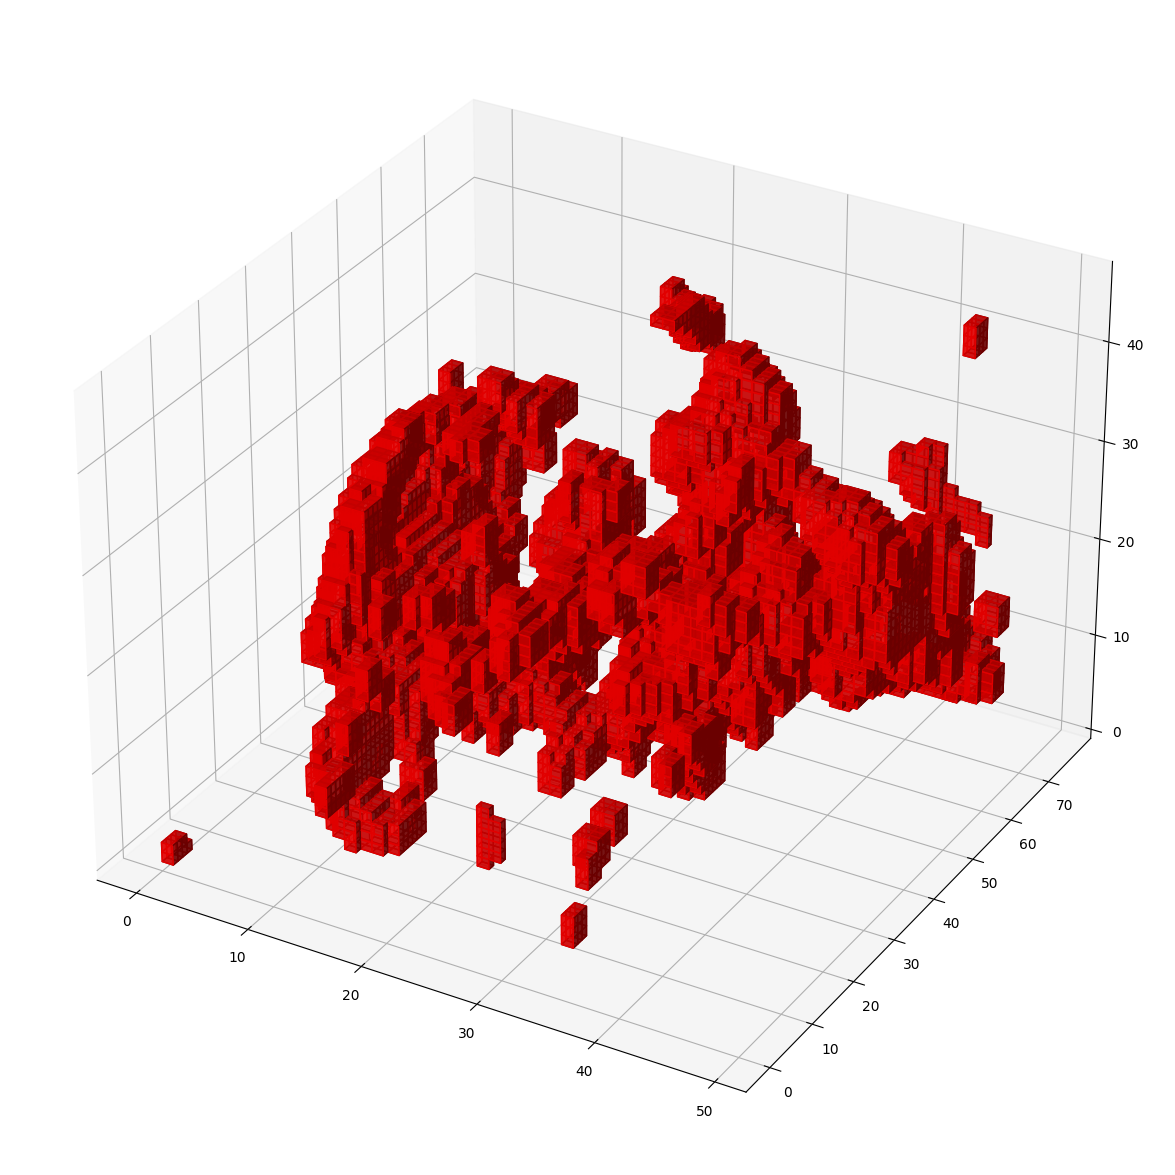

In [8]:
# Bounding Volume을 시각화하는 함수
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
lesion_mask = lesion_mask[..., 0]
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가

In [9]:
# 004번 환자 폴더에서 실행
patient_folder_name = str(4).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images, color_info = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 가장 큰 병변의 Bounding Volume을 찾기
voxel, min_corner, max_corner, lesion_mask = find_largest_lesion_and_bounding_volume(images, color_info)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(voxel.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  최소 모서리: {min_corner}")
print(f"  최대 모서리: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

Detected lesion pixels: 0
Detected lesion pixels: 40
Detected lesion pixels: 63
Detected lesion pixels: 56
Detected lesion pixels: 21
Detected lesion pixels: 14
Detected lesion pixels: 33
Detected lesion pixels: 42
Detected lesion pixels: 50
Detected lesion pixels: 9
Detected lesion pixels: 0
Detected lesion pixels: 12
Detected lesion pixels: 21
Detected lesion pixels: 21
Detected lesion pixels: 64
Detected lesion pixels: 89
Detected lesion pixels: 102
Detected lesion pixels: 101
Detected lesion pixels: 94
Detected lesion pixels: 108
Detected lesion pixels: 106
Detected lesion pixels: 78
Detected lesion pixels: 97
Detected lesion pixels: 92
Detected lesion pixels: 127
Detected lesion pixels: 66
Detected lesion pixels: 73
Detected lesion pixels: 69
Detected lesion pixels: 48
Detected lesion pixels: 49
Detected lesion pixels: 43
Detected lesion pixels: 12
Detected lesion pixels: 65
Detected lesion pixels: 68
Detected lesion pixels: 69
Detected lesion pixels: 86
Detected lesion pixels: 15

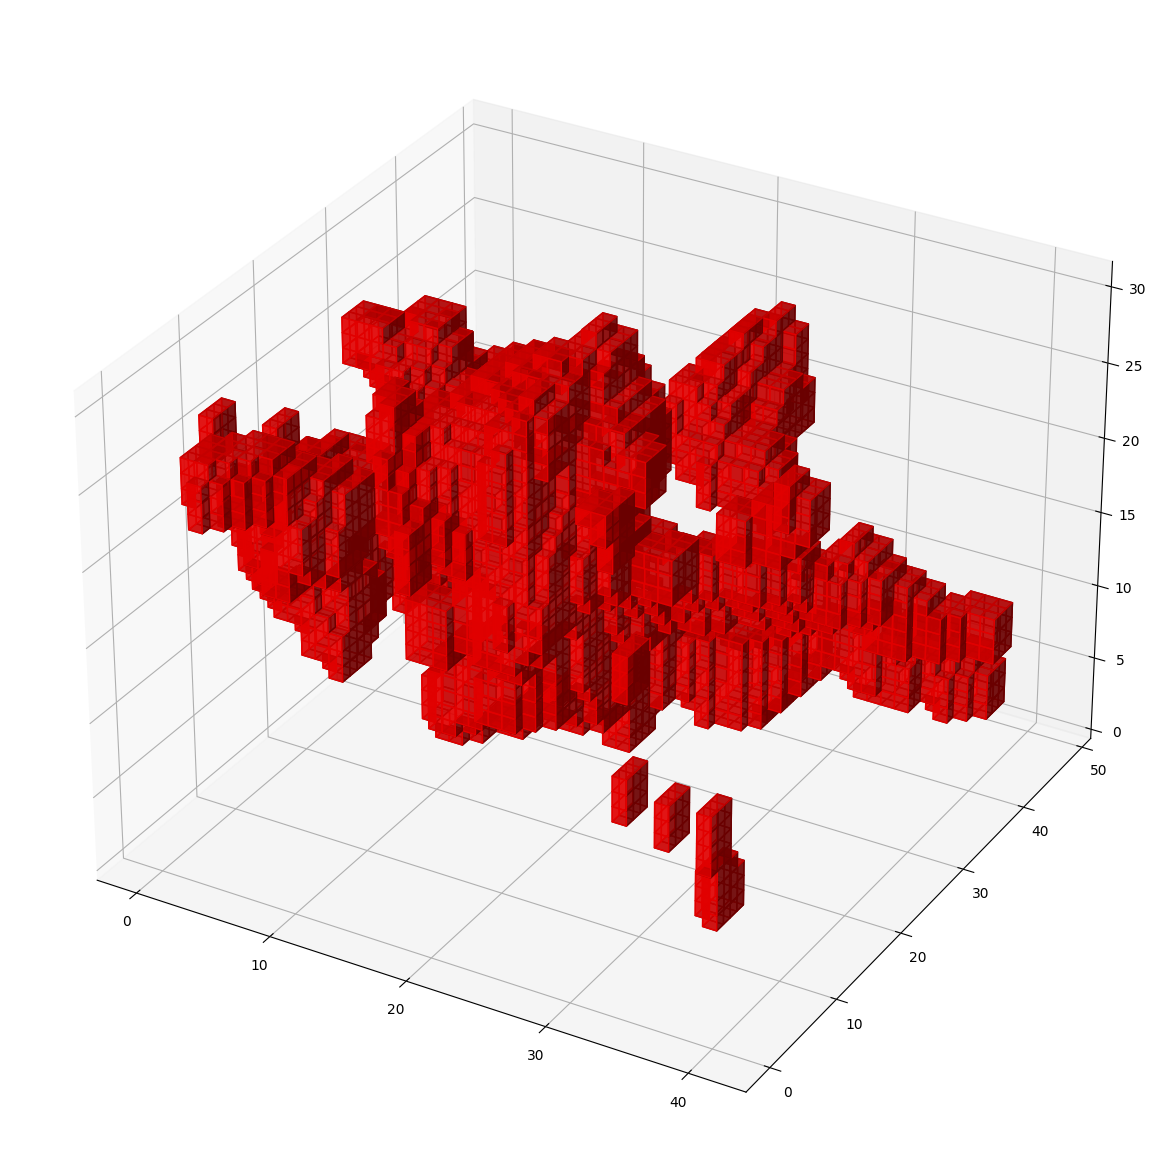

In [10]:
# Bounding Volume을 시각화하는 함수
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
lesion_mask = lesion_mask[..., 0]
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가

In [11]:
# 005번 환자 폴더에서 실행
patient_folder_name = str(5).zfill(3)
patient_folder_path = os.path.join(data_folder, patient_folder_name)

# 'cad'가 이름에 들어간 폴더 찾기
cad_folder = [os.path.join(patient_folder_path, f) for f in os.listdir(patient_folder_path) if 'cad' in f.lower()][0]

# cad 폴더 안의 유일한 폴더를 찾아 DICOM 파일이 있는 폴더로 설정
dicom_folder = [os.path.join(cad_folder, f) for f in os.listdir(cad_folder) if os.path.isdir(os.path.join(cad_folder, f))][0]

# DICOM 이미지들을 로드하기
images, color_info = load_patient_images(dicom_folder)

# 환자의 이미지 개수 출력
print(f"환자 {patient_folder_name}의 DICOM 이미지 개수: {len(images)}장")

# 가장 큰 병변의 Bounding Volume을 찾기
voxel, min_corner, max_corner, lesion_mask = find_largest_lesion_and_bounding_volume(images, color_info)

# 전체 3D 볼륨의 모서리를 구하기
total_min_corner = np.array([0, 0, 0])
total_max_corner = np.array(voxel.shape) - 1

# Bounding Volume 및 전체 볼륨의 정보를 출력
print(f"환자 {patient_folder_name}의 가장 큰 병변의 Bounding Volume:")
print(f"  최소 모서리: {min_corner}")
print(f"  최대 모서리: {max_corner}")
print(f"환자 {patient_folder_name}의 전체 3D 볼륨의 크기:")
print(f"  최소 모서리: {total_min_corner}")
print(f"  최대 모서리: {total_max_corner}")

Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 35
Detected lesion pixels: 32
Detected lesion pixels: 18
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 63
Detected lesion pixels: 103
Detected lesion pixels: 158
Detected lesion pixels: 217
Detected lesion pixels: 142
Detected lesion pixels: 122
Detected lesion pixels: 42
Detected lesion pixels: 16
Detected lesion pixels: 24
Detected lesion pixels: 16
Detected lesion pixels: 12
Detected lesion pixels: 0
Detected lesion pixels: 0
Detected lesion pixels: 9
Detected lesion pixels: 18
Detected lesion pixels: 9
Detected lesion pixels: 18
Detected lesion pixels: 9
Detected lesion pixels: 9
Detected lesion pixels: 9
Detected lesion pixels: 42
Detected lesion pixels: 42
Detected lesion pixels: 19
Detected lesion pixels: 30
Detected lesion pixels: 36
Detected lesion pixels: 40
Detected lesion pixels: 46
Detected lesion pixels: 36
Detected lesion pixels: 18
Detected

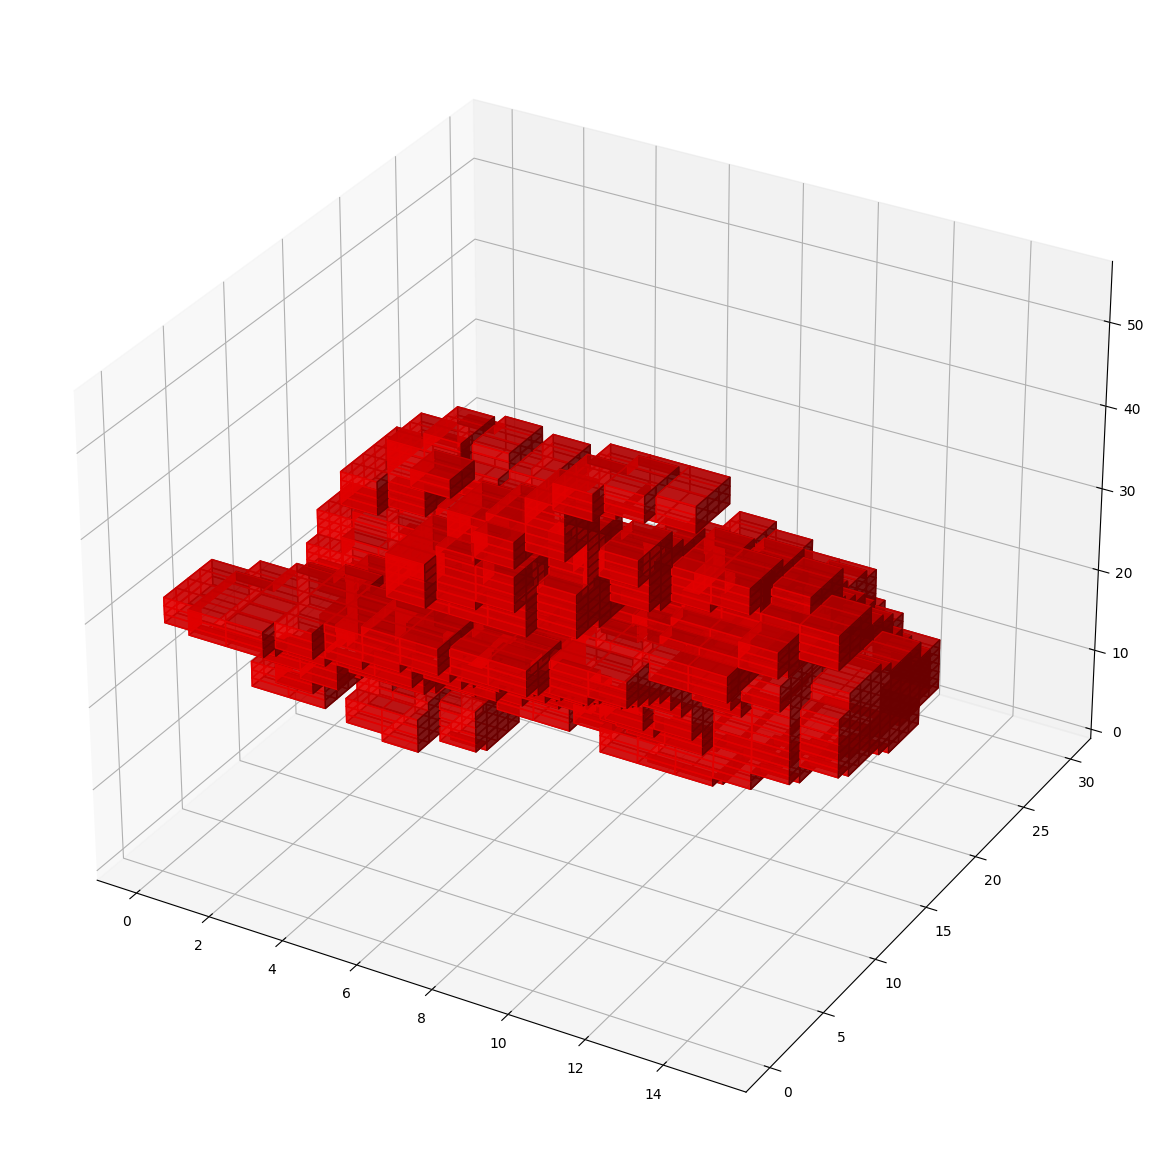

In [12]:
# Bounding Volume을 시각화하는 함수
def visualize_bounding_volume(lesion_mask, min_corner, max_corner):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Bounding Volume 내의 병변은 투명도를 높게 설정
    lesion_alpha = 0.7
    ax.voxels(
        lesion_mask[min_corner[0]:max_corner[0]+1, min_corner[1]:max_corner[1]+1, min_corner[2]:max_corner[2]+1],
        edgecolors='r',
        facecolors='r',
        alpha=lesion_alpha
    )

    plt.show()

# 가장 큰 병변의 Bounding Volume을 시각화
lesion_mask = lesion_mask[..., 0]
visualize_bounding_volume(lesion_mask, min_corner, max_corner)  # lesion_mask를 입력으로 추가